# Project: Estimating the Age of the Universe from Type Ia Supernovae Observations

The project analyzes observational data from the Pantheon+SH0ES dataset of Type Ia supernovae to estimate key cosmological parameters, including the Hubble constant ($H_0$) and the age of the universe. The approach includes:

- Plotting the Hubble diagram (distance modulus vs. redshift)
- Fitting a cosmological model to determine $H_0$ and $\Omega_m$
- Estimating the age of the universe based on model parameters
- Evaluating residuals to assess the modelâ€™s accuracy
- Investigating the impact of fixing $\Omega_m$
- Comparing results across low- and high-redshift supernovae



## Environment Setup

This project relies on the following Python libraries:

- `numpy` â€” numerical operations  
- `pandas` â€” data manipulation  
- `matplotlib` â€” data visualization  
- `scipy` â€” curve fitting and integration  
- `astropy` â€” physical constants and unit handling  

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.integrate import quad
from astropy.constants import c
from astropy import units as u

## Data Loading: Pantheon+SH0ES Sample

This analysis uses the Pantheon+SH0ES dataset, which provides calibrated observations of Type Ia supernovae across a broad redshift range. The data include redshifts corrected for various systematic effects, distance moduli, and associated uncertainties.

The dataset is space-delimited and includes comment lines (prefixed with `#`), which are ignored during loading.

For this project, I focus on the following key columns:

- `zHD`: Redshift used in the Hubble diagram  
- `MU_SH0ES`: Distance modulus calibrated using SH0ES  
- `MU_SH0ES_ERR_DIAG`: Diagonal uncertainty on the distance modulus  

The dataset file can be obtained from the [Pantheon+SH0ES Data Release](https://github.com/PantheonPlusSH0ES/DataRelease/blob/main/Pantheon%2B_Data/4_DISTANCES_AND_COVAR/Pantheon%2BSH0ES.dat).




In [17]:
# Local file path
file_path = "Pantheon+SH0ES.dat"

# Load the file
df = pd.read_csv(file_path,comment = '#', delim_whitespace=True)

# See structure
print(df.head())

             CID  IDSURVEY      zHD   zHDERR     zCMB  zCMBERR     zHEL  \
0         2011fe        51  0.00122  0.00084  0.00122  0.00002  0.00082   
1         2011fe        56  0.00122  0.00084  0.00122  0.00002  0.00082   
2         2012cg        51  0.00256  0.00084  0.00256  0.00002  0.00144   
3         2012cg        56  0.00256  0.00084  0.00256  0.00002  0.00144   
4  1994DRichmond        50  0.00299  0.00084  0.00299  0.00004  0.00187   

   zHELERR  m_b_corr  m_b_corr_err_DIAG  ...  PKMJDERR  NDOF   FITCHI2  \
0  0.00002   9.74571           1.516210  ...    0.1071    36   26.8859   
1  0.00002   9.80286           1.517230  ...    0.0579   101   88.3064   
2  0.00002  11.47030           0.781906  ...    0.0278   165  233.5000   
3  0.00002  11.49190           0.798612  ...    0.0667    55  100.1220   
4  0.00004  11.52270           0.880798  ...    0.0522   146  109.8390   

    FITPROB  m_b_corr_err_RAW  m_b_corr_err_VPEC  biasCor_m_b  biasCorErr_m_b  \
0  0.864470            

C:\Users\lenovo\AppData\Local\Temp\ipykernel_27088\2889242673.py:5: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file_path,comment = '#', delim_whitespace=True)


In [4]:
# All the columns in the dataset
print(df.columns)

Index(['CID', 'IDSURVEY', 'zHD', 'zHDERR', 'zCMB', 'zCMBERR', 'zHEL',
       'zHELERR', 'm_b_corr', 'm_b_corr_err_DIAG', 'MU_SH0ES',
       'MU_SH0ES_ERR_DIAG', 'CEPH_DIST', 'IS_CALIBRATOR', 'USED_IN_SH0ES_HF',
       'c', 'cERR', 'x1', 'x1ERR', 'mB', 'mBERR', 'x0', 'x0ERR', 'COV_x1_c',
       'COV_x1_x0', 'COV_c_x0', 'RA', 'DEC', 'HOST_RA', 'HOST_DEC',
       'HOST_ANGSEP', 'VPEC', 'VPECERR', 'MWEBV', 'HOST_LOGMASS',
       'HOST_LOGMASS_ERR', 'PKMJD', 'PKMJDERR', 'NDOF', 'FITCHI2', 'FITPROB',
       'm_b_corr_err_RAW', 'm_b_corr_err_VPEC', 'biasCor_m_b',
       'biasCorErr_m_b', 'biasCor_m_b_COVSCALE', 'biasCor_m_b_COVADD'],
      dtype='object')


In [5]:

redshift_data = df['zHD']                           # Redshift for the hubble diagram
distance_mod = df['MU_SH0ES']                       # mu = m - M = Apparent Brightness - Absolute Brightness, This can indicate the distance.
uncertainty = df['MU_SH0ES_ERR_DIAG']               # Uncertainty in distance modulus

print(redshift_data.head())
print(distance_mod.head())
print(uncertainty.head())


0    0.00122
1    0.00122
2    0.00256
3    0.00256
4    0.00299
Name: zHD, dtype: float64
0    28.9987
1    29.0559
2    30.7233
3    30.7449
4    30.7757
Name: MU_SH0ES, dtype: float64
0    1.516450
1    1.517470
2    0.782372
3    0.799068
4    0.881212
Name: MU_SH0ES_ERR_DIAG, dtype: float64


## Hubble Diagram Visualization

The Hubble diagram illustrates the relationship between redshift ($z$) and distance modulus ($\mu$). This fundamental plot in observational cosmology enables comparison of supernova data with theoretical predictions from cosmological models.

A logarithmic scale is applied to the redshift axis to effectively display supernovae spanning both low and high redshift regimes.



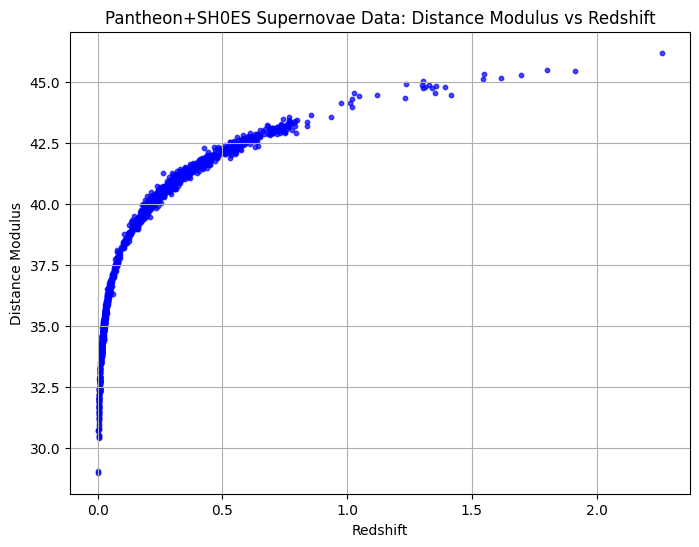

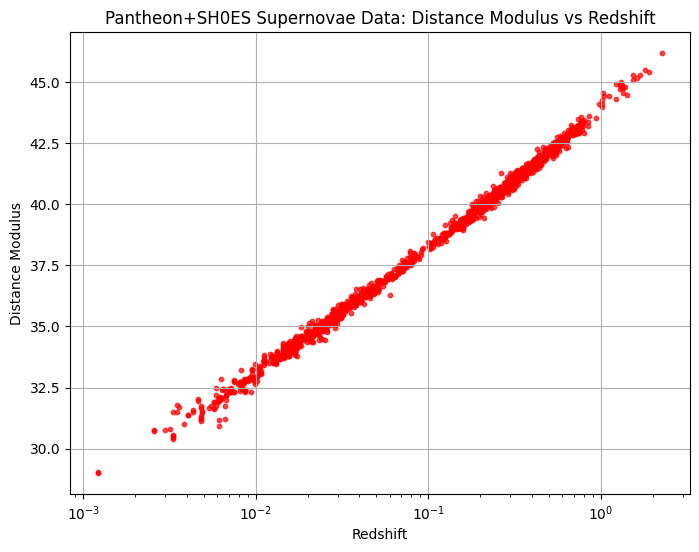

In [6]:
# Write a code to plot the distance modulus and the redshift (x-axis), label them accordingly. 


z = df['zHD']
mu = df['MU_SH0ES']

# Create the plot
plt.figure(figsize=(8,6))
plt.scatter(z, mu, s=10, color='blue', alpha=0.7)

# Label axes
plt.xlabel('Redshift')
plt.ylabel('Distance Modulus')
plt.title('Pantheon+SH0ES Supernovae Data: Distance Modulus vs Redshift')

# Show grid and plot
plt.grid(True)
plt.show()



# Using log scale in x-axis

# Create the plot
plt.figure(figsize=(8,6))
plt.scatter(z, mu, s=10, color='red', alpha=0.7)

# Label axes
plt.xlabel('Redshift')
plt.xscale('log')
plt.ylabel('Distance Modulus')
plt.title('Pantheon+SH0ES Supernovae Data: Distance Modulus vs Redshift')

# Show grid and plot
plt.grid(True)
plt.show()


## Cosmological Model Definition

The analysis adopts the flat $\Lambda\mathrm{CDM}$ cosmological model as the theoretical framework. The key components are:

- The dimensionless Hubble parameter:
  $$
  E(z) = \sqrt{\Omega_m (1+z)^3 + (1 - \Omega_m)}
  $$

- The distance modulus:
  $$
  \mu(z) = 5 \log_{10}(d_L / \text{Mpc}) + 25
  $$

- The luminosity distance:
  $$
  d_L(z) = (1 + z) \cdot \frac{c}{H_0} \int_0^z \frac{dz'}{E(z')}
  $$

These expressions enable calculation of the theoretical distance modulus for a given redshift $z$, Hubble constant $H_0$, and matter density parameter $\Omega_m$.



In [7]:
# Define the E(z) for flat LCDM

def E(z, Omega_m):
    return np.sqrt(Omega_m * (1 + z)**3 + (1 - Omega_m))

# Luminosity distance in Mpc, Using scipy quad to integrate.

def luminosity_distance(z, H0, Omega_m):
    c = 299792.458  # speed of light in km/s
    integrand = lambda x: 1.0 / E(x, Omega_m)
    integral, _ = quad(integrand, 0, z)
    return (1 + z) * (c / H0) * integral


# Theoretical distance modulus, use above function inside mu_theory to compute luminosity distance 

def mu_theory(z, H0, Omega_m):
    ret = []
    for zi in z:
        d_L = luminosity_distance(zi, H0, Omega_m)  # in Mpc
        ret.append(5 * np.log10(d_L) + 25)
    ret = np.array(ret)
    return ret




##  Model Fitting to Supernova Observations

The next step involves fitting the theoretical distance modulus model $\mu(z)$ to the observed supernova data. This fitting process aims to determine the best-fit values of the Hubble constant $H_0$ and the matter density parameter $\Omega_m$, as well as their uncertainties.

To perform this, a non-linear least squares optimization is applied using the `curve_fit` function from `scipy.optimize`. The inputs for the fitting procedure include the observed distance moduli $\mu$, their corresponding redshifts $z$, and measurement uncertainties.

For the initial parameter estimates, the values chosen are:
- $H_0 = 70\, \text{km s}^{-1} \text{Mpc}^{-1}$
- $\Omega_m = 0.3$

In [8]:
# Initial guess: H0 = 70, Omega_m = 0.3
H_guess = 70
omega_guess = 0.3


# Write a code for fitting and taking error out of the parameters
x_data = z
y_data = mu
p0 = [H_guess, omega_guess]
# sigma =  uncertainty for errors and more reliability 

popt, pcov = curve_fit(mu_theory, x_data, y_data, p0, sigma = uncertainty)

H0_fit = popt[0]
Omega_m_fit = popt[1]

H0_err = np.sqrt(pcov[0,0])        # np.sqrt for arrays
Omega_m_err = np.sqrt(pcov[1,1]) 


print(f"Fitted H0 = {H0_fit:.2f} Â± {H0_err:.2f} km/s/Mpc")
print(f"Fitted Omega_m = {Omega_m_fit:.3f} Â± {Omega_m_err:.3f}")


Fitted H0 = 72.97 Â± 0.17 km/s/Mpc
Fitted Omega_m = 0.351 Â± 0.012


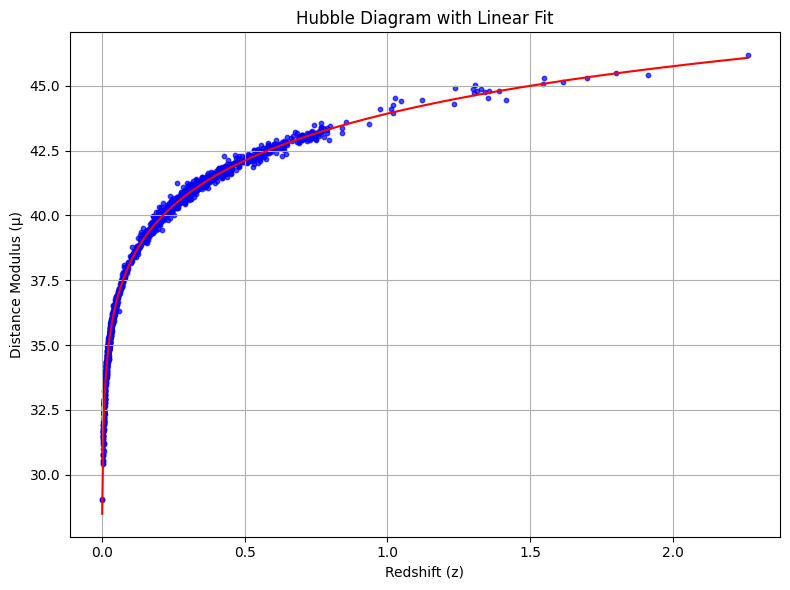

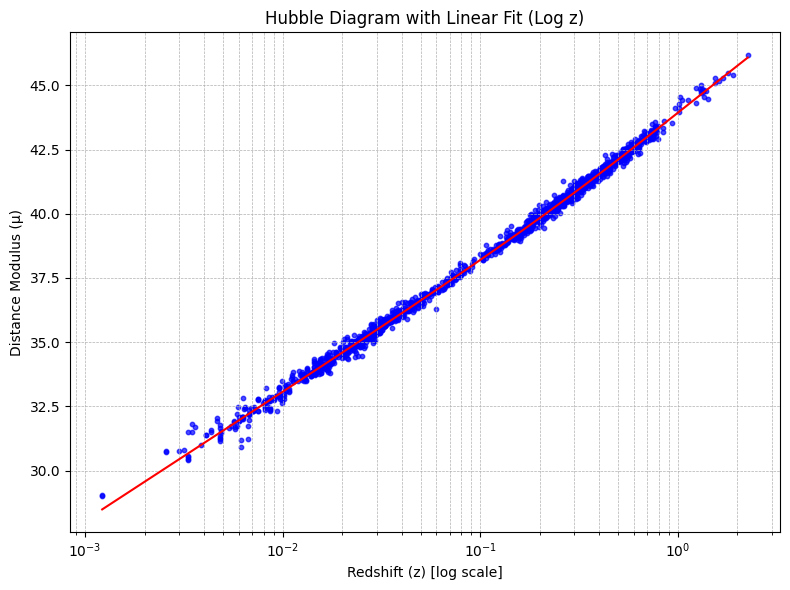

In [18]:
# fitted model values
z_fit = np.linspace(min(z), max(z), 500)
mu_fit = mu_theory(z_fit, H0_fit, Omega_m_fit)


# Plot Hubble Diagram
plt.figure(figsize=(8, 6))
plt.scatter(z, mu, s=10, color='blue', alpha=0.7)
#plt.errorbar(z, mu, yerr=uncertainty, fmt='o', markersize=4, alpha=0.6, label='Observed Data')
plt.plot(z_fit, mu_fit, 'red')
plt.xlabel('Redshift (z)')
plt.ylabel('Distance Modulus (Î¼)')
plt.title('Hubble Diagram with Linear Fit')
plt.grid(True)
plt.tight_layout()
plt.show()



# Model fit values
z_fit = np.linspace(min(z[z > 0]), max(z), 500)  # Avoid log(0)
mu_fit = mu_theory(z_fit, H0_fit, Omega_m_fit)

# Plotting
plt.figure(figsize=(8, 6))
plt.scatter(z, mu, s=10, color='blue', alpha=0.7)
#plt.errorbar(z, mu, yerr=uncertainty, fmt='o', markersize=4, alpha=0.6, label='Observed Data')
plt.plot(z_fit, mu_fit, 'red')
plt.xscale('log')  # Set log scale
plt.xlabel('Redshift (z) [log scale]')
plt.ylabel('Distance Modulus (Î¼)')
plt.title('Hubble Diagram with Linear Fit (Log z)')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


## Estimation of the Universeâ€™s Age

Using the obtained fitted parameters $H_0$ and $\Omega_m$, the age of the universe $t_0$ is estimated by numerically evaluating the integral:

$$
t_0 = \frac{1}{H_0} \int_0^{z_{\text{max}}} \frac{1}{(1 + z) E(z, \Omega_m)} \, dz
$$

where $z_{\text{max}}$ is a sufficiently large upper limit chosen to approximate infinity.

The Hubble constant $H_0$ is converted to units of $\text{Gyr}^{-1}$ to ensure consistent units. This provides a check on the cosmological model by comparing the estimated age to values from other probes like Planck CMB measurements.




In [10]:
# Function for age of the universe as given above

def age_of_universe(H0, Omega_m):
    integrand = lambda z: 1.0 / ((1 + z) * E(z, Omega_m))
    integral, _ = quad(integrand, 0, 10000)  # z_max = 10000
    H0_gyr = (H0 * (u.km / u.s / u.Mpc)).to(1 / u.Gyr).value
    t0 = integral / H0_gyr 

    return t0 # in Gyr

t0 = age_of_universe(H0_fit, Omega_m_fit)
print(f"Estimated age of Universe: {t0:.2f} Gyr")


Estimated age of Universe: 12.36 Gyr


## ðŸ“Š Residual Analysis

To assess the goodness of fit of the cosmological model, we calculate the residuals defined as:

$$
\text{Residual} = \mu_{\mathrm{obs}} - \mu_{\mathrm{model}}
$$

Plotting the residuals as a function of redshift allows identification of systematic deviations, biases, or outliers. Ideally, residuals should be randomly distributed around zero with no discernible patterns, indicating an adequate model fit.



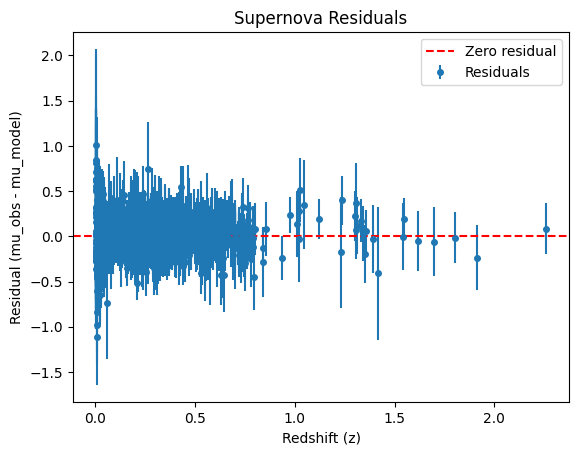

In [11]:
# Write the code to find residual by computing mu_theory and then plot
mu_model = mu_theory(z, H0_fit, Omega_m_fit)

# Residuals
residuals = mu - mu_model

# Plot Residual vs Redshift
plt.errorbar(z, residuals, yerr=uncertainty, fmt='o', markersize=4, label='Residuals')
plt.axhline(0, color='red', linestyle='--', label='Zero residual')
plt.xlabel('Redshift (z)')
plt.ylabel('Residual (mu_obs - mu_model)')
plt.title('Supernova Residuals')
plt.legend()
plt.show()


## Fixed Matter Density

To reduce parameter degeneracy,  $ \Omega_m = 0.3 $ is fixed and the model is fit only for the Hubble constant $ H_0 $.



In [13]:
def mu_fixed_Om(z, H0):
    return mu_theory(z, H0, Omega_m=0.3)

# Fitting with this fixed value
H_guess = 70
x_data = z
y_data = mu
p0 = [H_guess]
# sigma =  uncertainty for errors and more reliability 

popt, pcov = curve_fit(mu_fixed_Om, x_data, y_data, p0, sigma = uncertainty)

H0_fit = popt[0]


H0_err = np.sqrt(pcov[0,0])        # np.sqrt for arrays



print(f"Fitted H0 = {H0_fit:.2f} Â± {H0_err:.2f} km/s/Mpc")


Fitted H0 = 73.53 Â± 0.11 km/s/Mpc


## Comparison of Low-Redshift and High-Redshift Subsamples

The dataset is divided into two subsamples based on redshift:
- **Low-redshift** supernovae ($z < 0.1$)
- **High-redshift** supernovae ($z \geq 0.1$)

Separate fits are performed on each subset with the matter density parameter fixed at $\Omega_m = 0.3$. This analysis investigates possible variations or systematic differences in the inferred Hubble constant $H_0$ across redshift ranges.



In [14]:
# Split the data for the three columns 

z_split = 0.1

mask_low = x_data < z_split
mask_high = x_data >= z_split

x_low = x_data[mask_low]
y_low = y_data[mask_low]
uncertainty_low = uncertainty[mask_low]

x_high = x_data[mask_high]
y_high = y_data[mask_high]
uncertainty_high = uncertainty[mask_high]

popt_low, pcov_low = curve_fit(mu_fixed_Om, x_low, y_low, p0=[H_guess], sigma=uncertainty_low)
popt_high, pcov_high = curve_fit(mu_fixed_Om, x_high, y_high, p0=[H_guess], sigma=uncertainty_high)

H0_low = popt_low[0]
H0_high = popt_high[0]


print(f"Low-z (z < {z_split}): Hâ‚€ = {H0_low:.2f} km/s/Mpc")
print(f"High-z (z â‰¥ {z_split}): Hâ‚€ = {H0_high:.2f} km/s/Mpc")


Low-z (z < 0.1): Hâ‚€ = 73.01 km/s/Mpc
High-z (z â‰¥ 0.1): Hâ‚€ = 73.85 km/s/Mpc


## Summary and Outlook

To contextualize the fitted parameters obtained in this analysis, the fitted values are compared with the values reported in the Pantheon+ collaboration paper ([Pantheon+, 2023](https://arxiv.org/pdf/2310.11727)).

**Published Pantheon+ Results**  
- $\Omega_m = 0.36 \pm 0.02$  
- $H_0 = 72.83 \pm 0.23 \, \mathrm{km/s/Mpc}$

**Fitted Parameters from This Analysis**  
- $\Omega_m = 0.351 \pm 0.012$  
- $H_0 = 72.97 \pm 0.17 \, \mathrm{km/s/Mpc}$

**Estimated Age of the Universe (from fitted parameters)**  
- $t_0 = 12.36 \, \mathrm{Gyr}$  
- *Planck 2018 CMB estimate:* $t_0 = 13.787 \pm 0.02 \, \mathrm{Gyr}$

Both the fitted values and uncertainties are in good agreement with those reported by the Pantheon+ collaboration. Minor deviations may result from factors such as dataset selection, numerical integration limits, or the specific fitting methodology. In future work, further analysis will explore alternative cosmological models, including non-flat geometries such as spherical (closed) and hyperbolic (open) universes. These models will be used to recompute cosmological predictionsâ€”particularly the age of the universeâ€”and compare them with results from the flat $\Lambda\mathrm{CDM}$ model and observational benchmarks.


